In [32]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.utils import median_survival_times
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter
from lifelines import WeibullAFTFitter

In [2]:
data = pd.read_csv("cancer.csv", index_col = 0)
data.head()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
1,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
3,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
5,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


In [3]:
print(data.shape)

(228, 10)


In [4]:
data = data[['time', 'status', 'age', 'sex', 'ph.ecog', 'ph.karno','pat.karno', 'meal.cal', 'wt.loss']]
data["status"] = data["status"] - 1
data["sex"] = data["sex"] - 1
data.head()

,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
1,306,1,74,0,1.0,90.0,100.0,1175.0,NaN
2,455,1,68,0,0.0,90.0,90.0,1225.0,15.0
3,1010,0,56,0,0.0,90.0,90.0,NaN,15.0
4,210,1,57,0,1.0,90.0,60.0,1150.0,11.0
5,883,1,60,0,0.0,100.0,90.0,NaN,0.0


### Missing data

In [5]:
data.isnull().sum()

time          0
status        0
age           0
sex           0
ph.ecog       1
ph.karno      1
pat.karno     3
meal.cal     47
wt.loss      14
dtype: int64

In [6]:
data["ph.karno"].fillna(data["ph.karno"].mean(), inplace = True)
data["pat.karno"].fillna(data["pat.karno"].mean(), inplace = True)
data["meal.cal"].fillna(data["meal.cal"].mean(), inplace = True)
data["wt.loss"].fillna(data["wt.loss"].mean(), inplace = True)
data.dropna(inplace=True)
data["ph.ecog"] = data["ph.ecog"].astype("int64")

### Data

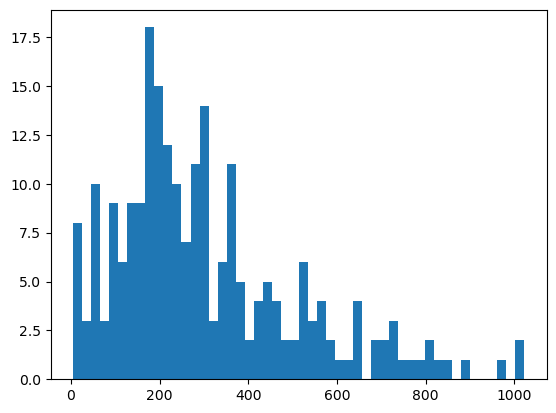

In [7]:
T = data["time"]
E = data["status"]
plt.hist(T, bins = 50)
plt.show()

### Kaplan-Maier Curve Estimation (Non-Parametric)

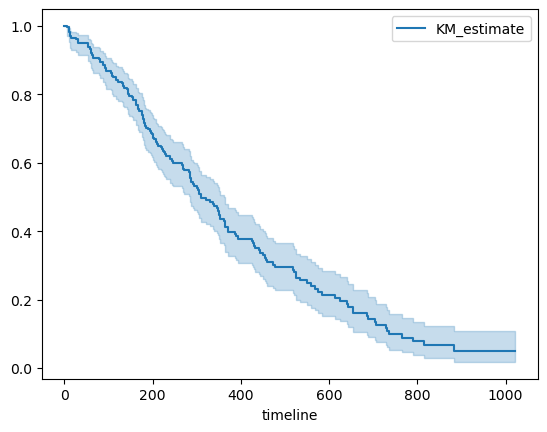

In [9]:
kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()
plt.show()

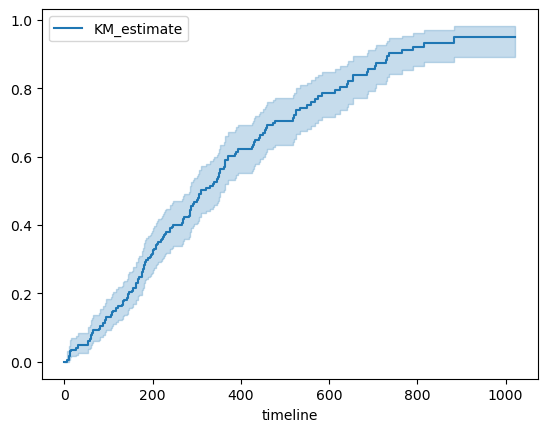

In [10]:
kmf.plot_cumulative_density()
plt.show()

### Median Survival Time and Confidence Intervals

In [12]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

310.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   284.0                   361.0


Here, the median survival time is 310 days, which indicates that 50% of the sample live 310 days and 50% dies within this time. The 95% CI lower limit is 284 days, while the upper limit is 361 days.

### KM Plot for Gender/Sex Categories

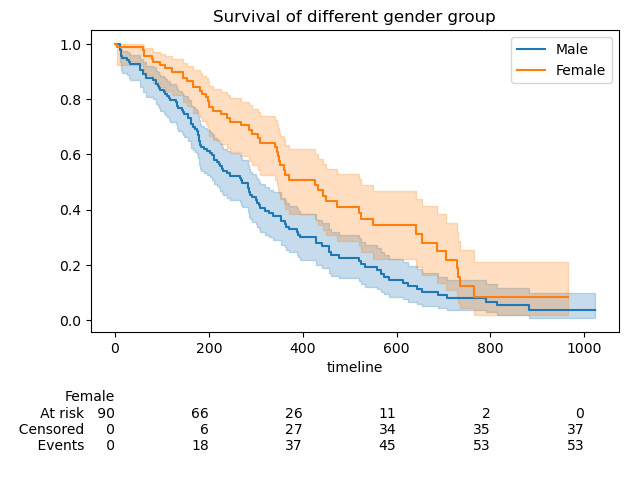

In [14]:
ax = plt.subplot(111)

m = (data["sex"] == 0)

kmf.fit(durations = T[m], event_observed = E[m], label = "Male")
kmf.plot_survival_function(ax = ax)

kmf.fit(T[~m], event_observed = E[~m], label = "Female")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)

plt.title("Survival of different gender group")
plt.show()

### KM Plot for ph.ecog Categories

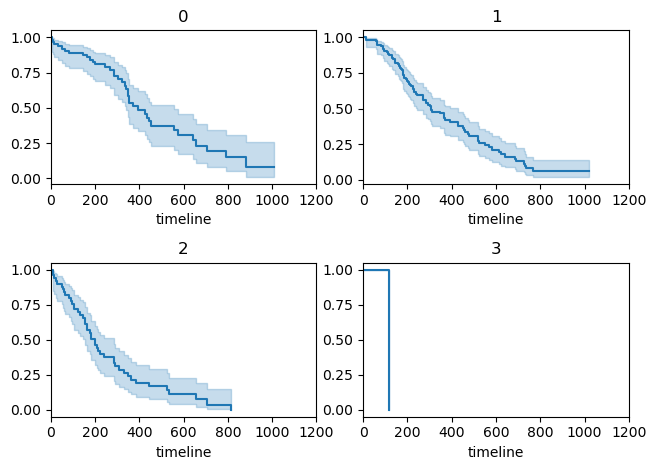

In [15]:
ecog_types = data.sort_values(by = ['ph.ecog'])["ph.ecog"].unique()

for i, ecog_types in enumerate(ecog_types):
  ax = plt.subplot(2, 2, i + 1)
  ix = data['ph.ecog'] == ecog_types
  kmf.fit(T[ix], E[ix], label = ecog_types)
  kmf.plot_survival_function(ax = ax, legend = False)
  plt.title(ecog_types)
  plt.xlim(0, 1200)
    
plt.tight_layout()
plt.show()

In [16]:
data['ph.ecog'].value_counts()

ph.ecog
1    113
0     63
2     50
3      1
Name: count, dtype: int64

### Cox Proportional Hazard Model (Semi-Parametric)

**Cox-PH Model Assumptions**  
  
Cox proportional hazards regression model assumptions includes:  
  
* Independence of survival times between distinct individuals in the sample  
* A multiplicative relationship between the predictors and the hazard, and  
* A constant hazard ratio over time  

**Definition of Hazard and Hazard Ratio**  
  
* Hazard is defined as the slope of the survival curve. It is a measure of how rapidly subjects are dying.  
* The hazard ratio compares two groups. If the hazard ratio is 2.0, then the rate of deaths in one group is twice the rate in the other group.

In [17]:
dummies_ecog = pd.get_dummies(data["ph.ecog"], prefix = 'ecog')
dummies_ecog.head(4)

,ecog_0,ecog_1,ecog_2,ecog_3
1,False,True,False,False
2,True,False,False,False
3,True,False,False,False
4,False,True,False,False


In [18]:
dummies_ecog = dummies_ecog[["ecog_1", "ecog_2"]]
data = pd.concat([data, dummies_ecog], axis = 1)
data = data.drop("ph.ecog", axis = 1)
data.head()

,time,status,age,sex,ph.karno,pat.karno,meal.cal,wt.loss,ecog_1,ecog_2
1,306,1,74,0,90.0,100.0,1175.000000,9.831776,True,False
2,455,1,68,0,90.0,90.0,1225.000000,15.000000,False,False
3,1010,0,56,0,90.0,90.0,928.779006,15.000000,False,False
4,210,1,57,0,90.0,60.0,1150.000000,11.000000,True,False
5,883,1,60,0,100.0,90.0,928.779006,0.000000,False,False


In [20]:
cph = CoxPHFitter()
cph.fit(data, duration_col = 'time', event_col = 'status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 227 total observations, 63 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 227
number of events observed = 164
   partial log-likelihood = -726.94
         time fit was run = 2023-08-29 10:09:06 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
sex        -0.58       0.56       0.17            -0.92            -0.25                 0.40                 0.78
ph.karno    0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
pat.karno  -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00
meal.cal    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
wt.loss    -0.01       0.99       0.01            -0.02             0.00                 0.98                 1.00
ecog_1      0.56       1.74       0.24             0.09             1.02                 1.10                 2.77
ecog_2      1.08       2.94       0.37             0.35             1.80                 1.43                 6.08

            cmp to     z      p   -log2(p)
covariate                                 
age           0.00  1.37   0.17       2.54
sex           0.00 -3.41 <0.005      10.59
ph.karno      0.00  1.37   0.17       2.56
pat.karno     0.00 -1.82   0.07       3.87
meal.cal      0.00  0.11   0.92       0.13
wt.loss       0.00 -1.65   0.10       3.35
ecog_1        0.00  2.35   0.02       5.74
ecog_2        0.00  2.92 <0.005       8.15
---
Concordance = 0.65
Partial AIC = 1469.88
log-likelihood ratio test = 35.08 on 8 df
-log2(p) of ll-ratio test = 15.24

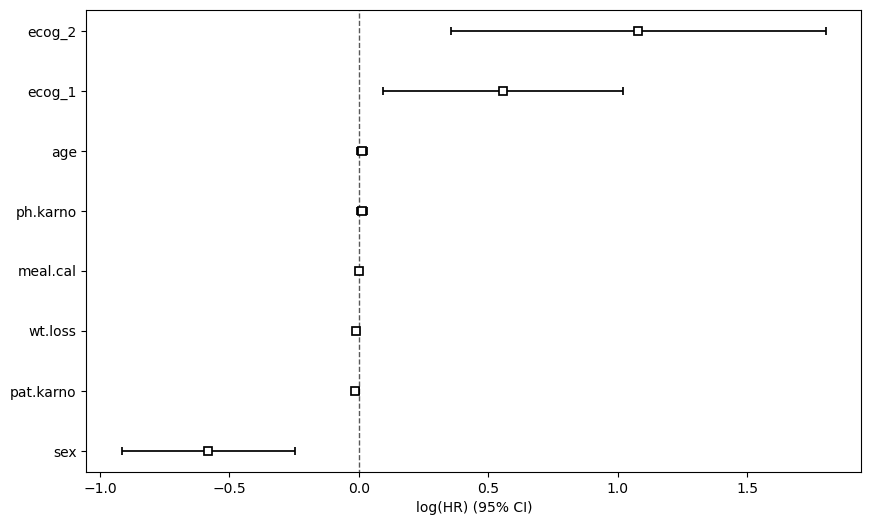

In [22]:
plt.subplots(figsize = (10, 6))
cph.plot()
plt.show()

<Axes: >

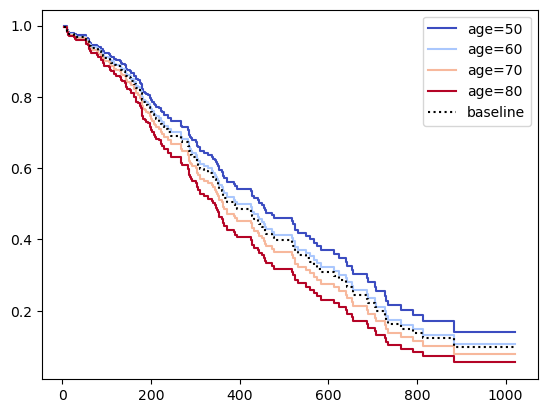

In [23]:
cph.plot_partial_effects_on_outcome(covariates = 'age', values = [50, 60, 70, 80], cmap = 'coolwarm')

### Check Proportional Hazard Assumption

In [24]:
cph.check_assumptions(data, p_value_threshold = 0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 227 total observations, 63 right-censored observations>
         test_name = proportional_hazard_test

---
                test_statistic    p  -log2(p)
age       km              0.35 0.55      0.86
          rank            0.14 0.71      0.50
ecog_1    km              2.31 0.13      2.96
          rank            2.14 0.14      2.80
ecog_2    km              1.88 0.17      2.55
          rank            1.47 0.23      2.15
meal.cal  km              5.13 0.02      5.41
          rank            4.53 0.03      4.91
pat.karno km              0.26 0.61      0.71
          rank            0.21 0.65      0.62
ph.karno  km              4.76 0.03      5.10
          rank            4.13 0.04      4.57
sex       km              2.71 0.10      3.33
          rank            2.58 0.11      3.21
wt.loss   km              0.01 0.93      0.11
          rank            0.04 0.85      0.24



1. Variable 'ph.karno' failed the non-proportional test: p-value is 0.0292.

   Advice 1: the functional form of the variable 'ph.karno' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'ph.karno' using pd.cut, and then specify it in
`strata=['ph.karno', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'meal.cal' failed the non-proportional test: p-value is 0.0235.

   Advice 1: the functional form of the variable 'meal.cal' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional

[]

In [26]:
results = proportional_hazard_test(cph, data, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 227 total observations, 63 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic    p  -log2(p)
age                  0.14 0.71      0.50
ecog_1               2.14 0.14      2.80
ecog_2               1.47 0.23      2.15
meal.cal             4.53 0.03      4.91
pat.karno            0.21 0.65      0.62
ph.karno             4.13 0.04      4.57
sex                  2.58 0.11      3.21
wt.loss              0.04 0.85      0.24

### Accelerated Failure Time (AFT) Model  
If the proportional hazard assumption criteria of Cox-PH model is not satisfied, in such instance, a better approach is to use a parametric model. Accelerated Failure Time (AFT) is one of the popular parametric model used in survival analysis.

#### Identifying the Best Fitted Distribution  
* Import distributions from lifelines library  
* Instantiate the class object and save inside a variable. For example, here the Weibull class object has been saved inside “wb”  
* Iterate through all model objects and fit with the time and event data  
* Print the AIC value  
* The distribution with the lowest AIC value presents the best fitted distribution

In [30]:
# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()

# Fit to data
for model in [wb, ex, log, loglogis]:
    model.fit(durations = data["time"], event_observed = data["status"])
    
    # Print AIC
    print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)

The AIC value for WeibullFitter is 2298.8561137465936
The AIC value for ExponentialFitter is 2314.2465289315023
The AIC value for LogNormalFitter is 2330.351968846968
The AIC value for LogLogisticFitter is 2313.0983586370508


In [33]:
weibull_aft = WeibullAFTFitter()
weibull_aft.fit(data, duration_col='time', event_col='status')
weibull_aft.print_summary(3)

<lifelines.WeibullAFTFitter: fitted with 227 total observations, 63 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 227
number of events observed = 164
           log-likelihood = -1129.849
         time fit was run = 2023-08-29 10:14:34 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                         
lambda_ age       -0.009      0.991      0.007           -0.022            0.004                0.978                1.004
        ecog_1    -0.402      0.669      0.166           -0.728           -0.076                0.483                0.927
        ecog_2    -0.802      0.448      0.260           -1.313           -0.292                0.269                0.747
        meal.cal  -0.000      1.000      0.000           -0.000            0.000                1.000                1.000
        pat.karno  0.009      1.010      0.005           -0.001            0.020                0.999                1.020
        ph.karno  -0.010      0.990      0.007           -0.023            0.002                0.977                1.002
        sex        0.418      1.519      0.123            0.177            0.660                1.193                1.935
        wt.loss    0.008      1.008      0.005           -0.001            0.017                0.999                1.017
        Intercept  6.819    915.166      0.884            5.086            8.552              161.742             5178.161
rho_    Intercept  0.333      1.395      0.062            0.212            0.454                1.236                1.575

                    cmp to      z       p   -log2(p)
param   covariate                                   
lambda_ age          0.000 -1.299   0.194      2.366
        ecog_1       0.000 -2.418   0.016      6.000
        ecog_2       0.000 -3.081   0.002      8.923
        meal.cal     0.000 -0.027   0.978      0.032
        pat.karno    0.000  1.846   0.065      3.946
        ph.karno     0.000 -1.579   0.114      3.128
        sex          0.000  3.392   0.001     10.494
        wt.loss      0.000  1.643   0.100      3.317
        Intercept    0.000  7.712 <0.0005     46.195
rho_    Intercept    0.000  5.380 <0.0005     23.676
---
Concordance = 0.646
AIC = 2279.697
log-likelihood ratio test = 35.159 on 8 df
-log2(p) of ll-ratio test = 15.287

* A unit increase in covariate indicates that the mean/median survival time will change by a factor of exp(coefficient).  
* If the coefficient is positive, then the exp(coefficient) will be >1, which will decelerate the incident/event time. Similarly, a negative coefficient will reduce the mean/median survival time.

In [34]:
print(weibull_aft.median_survival_time_)
print(weibull_aft.mean_survival_time_)

399.37056383406235
473.5931793808851


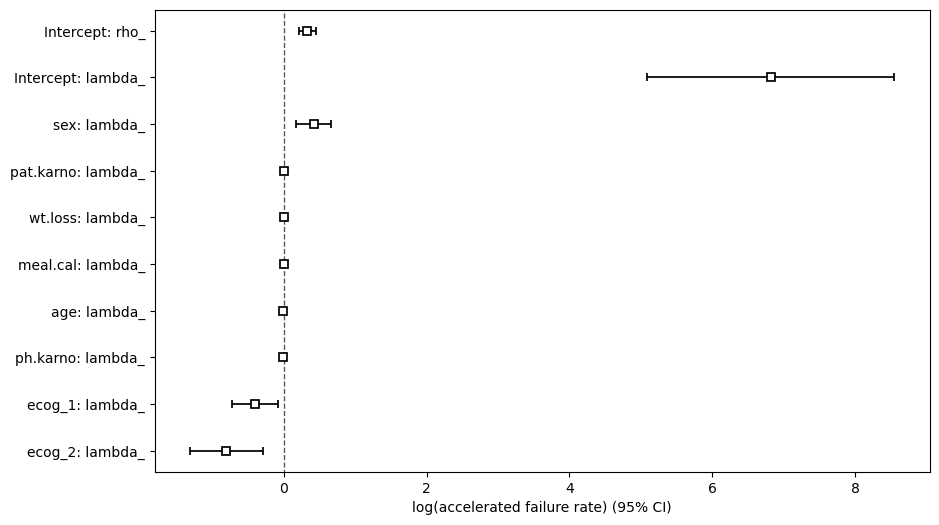

In [36]:
plt.subplots(figsize=(10, 6))
weibull_aft.plot()
plt.show()

### Plot Partial Effects on Outcome (Weibull Regression)

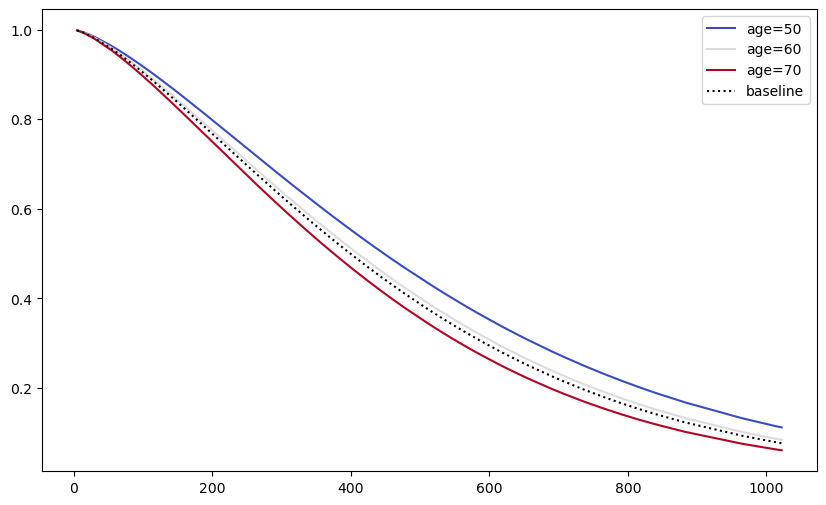

In [37]:
plt.subplots(figsize=(10, 6))
weibull_aft.plot_partial_effects_on_outcome('age', range(50, 80, 10), cmap='coolwarm')
plt.show()